In [1]:
import os
import pandas as pd
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [7]:
# Define paths
base_path = Path('Data/monkeypox_dataset')
splits = ['train', 'val', 'test']
classes = ['Chickenpox', 'Cowpox', 'Healthy', 'HFMD', 'Measles', 'Monkeypox', 'Normal']

Image counts per split/class:
        Chickenpox  Cowpox  Healthy  HFMD  Measles  Monkeypox  Normal
train         332     230      404   563      251       1551     206
val            93      65      116   160       72        407      44
test           66      35       50    82       43        241      43


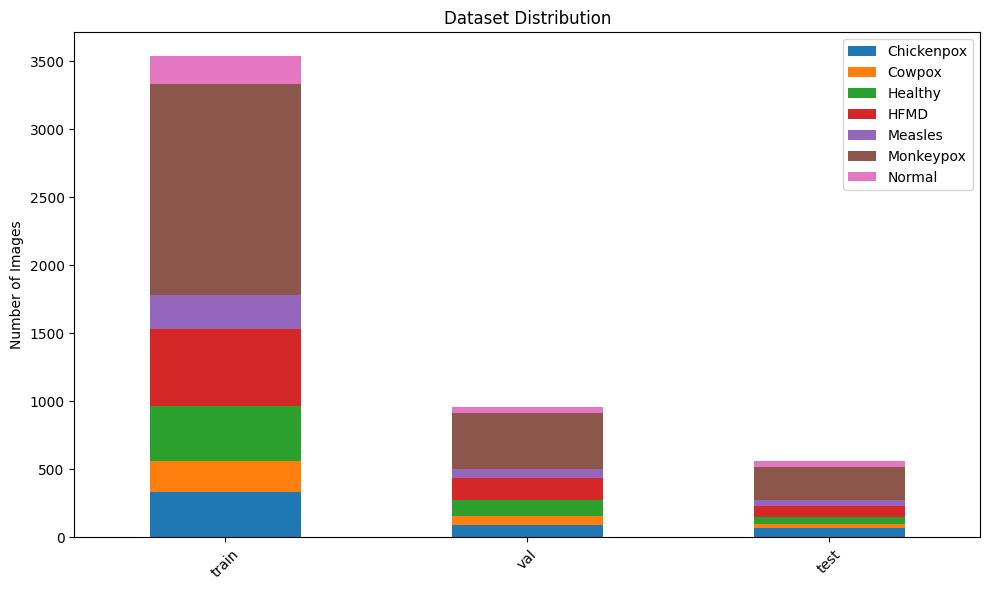

Total images per class:
 Chickenpox     491
Cowpox         330
Healthy        570
HFMD           805
Measles        366
Monkeypox     2199
Normal         293
dtype: int64
Grand total: 5054


In [8]:
# Step 1.1: Count images per class/split (check balance & empties)
counts = {}
for split in splits:
    split_path = base_path / split
    counts[split] = {cls: len(list((split_path / cls).glob('*.jpg'))) + len(list((split_path / cls).glob('*.png'))) for cls in classes}  # Adjust extensions if needed
df_counts = pd.DataFrame(counts).T
print("Image counts per split/class:\n", df_counts)
df_counts.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Dataset Distribution')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Total per class
total_per_class = df_counts.sum(axis=0)
print("Total images per class:\n", total_per_class)
print(f"Grand total: {total_per_class.sum()}")

In [10]:
%pip install ImageHash
# Step 1.2: Check for duplicates/redundancy (e.g., Healthy vs. Normal)
# Compute image hashes for quick dup detection (using PIL)
from imagehash import average_hash  # pip install ImageHash if not installed (but in your env, assume available or skip)

def get_image_hashes(folder_path):
    hashes = []
    for img_path in folder_path.glob('*.jpg'):  # Add .png etc.
        try:
            img = Image.open(img_path)
            hashes.append(str(average_hash(img)))
        except Exception:
            print(f"Corrupt: {img_path}")
    return hashes

healthy_train_hashes = get_image_hashes(base_path / 'train' / 'Healthy')
normal_train_hashes = get_image_hashes(base_path / 'train' / 'Normal')
common_hashes = set(healthy_train_hashes) & set(normal_train_hashes)
print(f"Potential duplicates between Healthy/Normal in train: {len(common_hashes)}")

# If >10% overlap, merge: e.g., mv Healthy/* Normal/ && rm -r Healthy (do manually after inspection)


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached ImageHash-4.3.2-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pywavelets-1.9.0-cp312-cp312-win_amd64.whl.metadata (7.6 kB)
Using cached ImageHash-4.3.2-py2.py3-none-any.whl (296 kB)
Using cached pywavelets-1.9.0-cp312-cp312-win_amd64.whl (4.2 MB)
Note: you may need to restart the kernel to use updated packages.
Potential duplicates between Healthy/Normal in train: 0


In [11]:
# Step 1.3: Remove corrupt images
def clean_folder(folder_path):
    corrupt = []
    for img_path in folder_path.glob('*.jpg'):
        try:
            with Image.open(img_path) as img:
                img.verify()  # Checks integrity
        except Exception:
            corrupt.append(img_path)
            img_path.unlink()  # Delete
    print(f"Removed {len(corrupt)} corrupt images from {folder_path}")

for split in splits:
    for cls in classes:
        clean_folder(base_path / split / cls)
print("Cleaning complete!")

Removed 0 corrupt images from Data\monkeypox_dataset\train\Chickenpox
Removed 0 corrupt images from Data\monkeypox_dataset\train\Cowpox
Removed 0 corrupt images from Data\monkeypox_dataset\train\Healthy
Removed 0 corrupt images from Data\monkeypox_dataset\train\HFMD
Removed 0 corrupt images from Data\monkeypox_dataset\train\Measles
Removed 0 corrupt images from Data\monkeypox_dataset\train\Monkeypox
Removed 0 corrupt images from Data\monkeypox_dataset\train\Normal
Removed 0 corrupt images from Data\monkeypox_dataset\val\Chickenpox
Removed 0 corrupt images from Data\monkeypox_dataset\val\Cowpox
Removed 0 corrupt images from Data\monkeypox_dataset\val\Healthy
Removed 0 corrupt images from Data\monkeypox_dataset\val\HFMD
Removed 0 corrupt images from Data\monkeypox_dataset\val\Measles
Removed 0 corrupt images from Data\monkeypox_dataset\val\Monkeypox
Removed 0 corrupt images from Data\monkeypox_dataset\val\Normal
Removed 0 corrupt images from Data\monkeypox_dataset\test\Chickenpox
Removed

IndexError: list index out of range

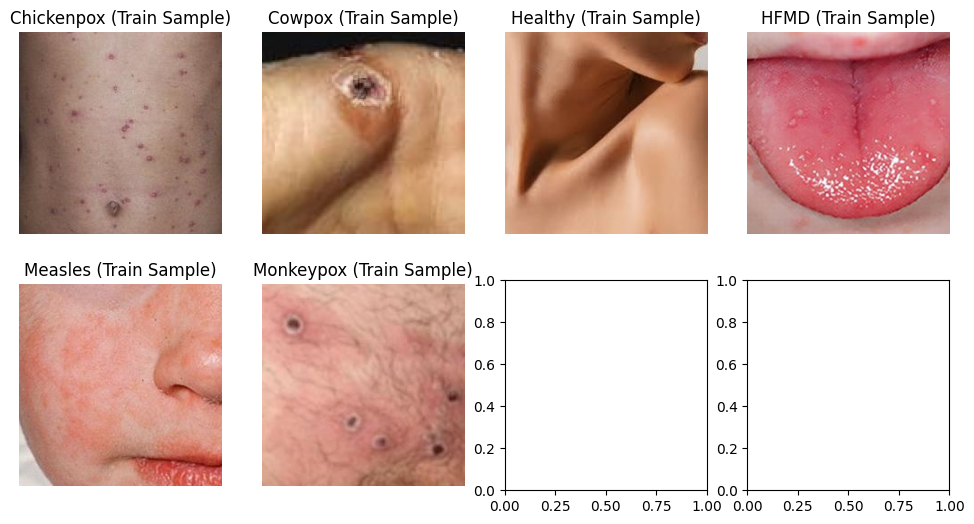

In [12]:
# Step 1.4: Visualize samples (sanity check)
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, cls in enumerate(classes[:4]):  # Sample first 4
    img_path = list((base_path / 'train' / cls).glob('*.jpg'))[0]
    img = Image.open(img_path)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'{cls} (Train Sample)')
    axes[0, i].axis('off')
for i, cls in enumerate(classes[4:]):  # Next 3
    img_path = list((base_path / 'train' / cls).glob('*.jpg'))[0]
    img = Image.open(img_path)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'{cls} (Train Sample)')
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()